# Classification modeling of two subreddits: r/DungeonsAndDragons or r/Warhammer40k

### Problem statement

The goal of this project is to create a model that can accurately determine which subreddit, of two, a post came form: r/DungeonsAndDragons, r/Warhammer40k.

### Overview
Data was scraped from the site Reddit. Reddit is a site on which users can join pages, subreddits, related to topics they are most interested in as well as vote on each post on subreddit. Users are also able to post themselves. Essentially users are able to decide what news is most important to him/her as well as contribute to it. Two subreddits will be used to train and test the data which contain text for titles and for the body of each post. A significant number of posts on each subreddit post a photo in the body with not text content Which reduces predictive capabilities for any posts that were only image based in comparison. In order to create the best model across the entire data set this project focuses only on title.

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer

In [2]:
# Read in data
df = pd.read_csv('../data/main_reddit_posts.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,title,score,id,url,comms_num,created,body,target1
0,Looking for a list of in-game books for my pla...,1,jc20y1,https://www.reddit.com/r/DungeonsAndDragons/co...,0,1602846302,Preferably books that can go in most any medie...,dnd
1,Need a bit of assistance,1,jc1p79,https://www.reddit.com/r/DungeonsAndDragons/co...,2,1602844973,"Dont know much, but I want to try and get into...",dnd
2,[OC][Adventure]Something Wicked at the Eldritc...,1,jc1n6h,https://www.reddit.com/r/DungeonsAndDragons/co...,0,1602844747,*A tiny farm has come under the influence of d...,dnd
3,My DnD battle station.,8,jc0a5d,https://i.redd.it/ijs910oywct51.jpg,1,1602839285,NaN,dnd
4,Some characters I've been making over the last...,2,jc03p8,https://imgur.com/a/zwtwud3,0,1602838561,NaN,dnd


In [3]:
# Show the number of each
df['target1'].value_counts()

40k    1291
dnd    1283
Name: target1, dtype: int64

In [4]:
# Show the baseline
df['target1'].value_counts(normalize=True)

40k    0.501554
dnd    0.498446
Name: target1, dtype: float64

## Experimental data analysis

In [5]:
def clean_data(df):
    # Dummify target
    df['target1'] = df['target1'].map({'dnd': 0, '40k': 1})
    # Drop columns would cause data leakage
    df.drop(columns=['url', 'created', 'id'], inplace=True)
    # Remove NA values for future analyses
    df['body'].fillna('999', inplace=True)
    # Look at distributions of length for title and body of each post
    df['body_wc'] = df['body'].map(lambda x: len(x.split()))
    df['title_wc'] = df['title'].map(lambda x: len(x.split()))
    return df

In [6]:
df = clean_data(df)
df.head()

,title,score,comms_num,body,target1,body_wc,title_wc
0,Looking for a list of in-game books for my pla...,1,0,Preferably books that can go in most any medie...,0,20,18
1,Need a bit of assistance,1,2,"Dont know much, but I want to try and get into...",0,18,5
2,[OC][Adventure]Something Wicked at the Eldritc...,1,0,*A tiny farm has come under the influence of d...,0,110,6
3,My DnD battle station.,8,1,999,0,1,4
4,Some characters I've been making over the last...,2,0,999,0,1,14


In [7]:
df.describe()

,score,comms_num,target1,body_wc,title_wc
count,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000
mean,117.124709,6.467366,0.501554,36.800699,10.999223
std,593.685615,16.771952,0.500095,105.444826,8.866633
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,0.000000,1.000000,5.000000
50%,9.000000,2.000000,1.000000,1.000000,8.000000
75%,35.000000,6.000000,1.000000,31.000000,14.000000
max,19074.000000,388.000000,1.000000,1995.000000,59.000000


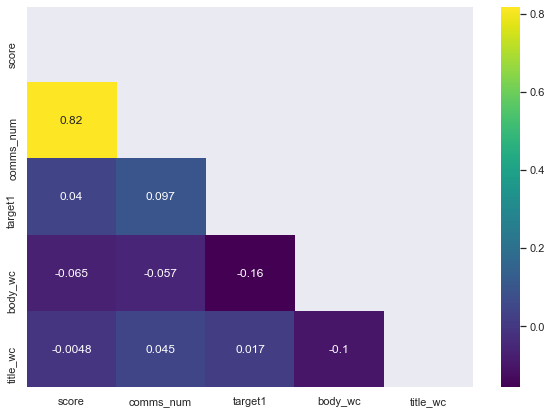

In [8]:
# There is not too much to see right now but it is worth looking at these correlations
# Establish size of figure.
plt.figure(figsize = (10,7))
# Get correlation of variables.
sns.set()
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr, mask = mask, annot = True, cmap='viridis');

The heat map above indicate there there is little correlation between the target and any of the original or engineered quantitative data. The high correlation between score and comm_num is not surprising as it is typical for users to upvote a post when they comment on it, increasing the score.

C:\Users\Julia Christensen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


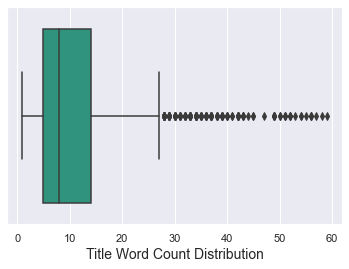

In [9]:
sns.boxplot(df['title_wc'], color='#20a387ff')
plt.xlabel('Title Word Count Distribution', fontsize=14) ;

While there are many outliers typically titles are only betwee 5 and 14 words. The documents that we are working with are relatively small and choosing the correct model and tuning the model will be important to improve the accuracy as much as possible.

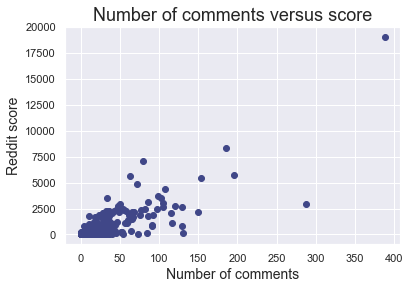

In [10]:
plt.scatter(df['comms_num'], df['score'], color='#404788ff')
plt.title('Number of comments versus score', fontsize=18)
plt.xlabel('Number of comments', fontsize=14)
plt.ylabel('Reddit score', fontsize=14);

The scatter plot above, supports the correlation between Reddit score and number of comments that was seen in the heat map.

## Word processing and analysis

In [11]:
# Vectorize corpus using CountCectorizer, and printing out the new shape of the data frame
cvec = CountVectorizer(stop_words = 'english', min_df = 3)
title_cv = cvec.fit_transform(df['title'])
titledf = pd.DataFrame(title_cv.todense(), columns=cvec.get_feature_names())
title_df = pd.concat([titledf, df], axis=1)
title_df.shape # Added over 1,000 columns of features

(2574, 1216)

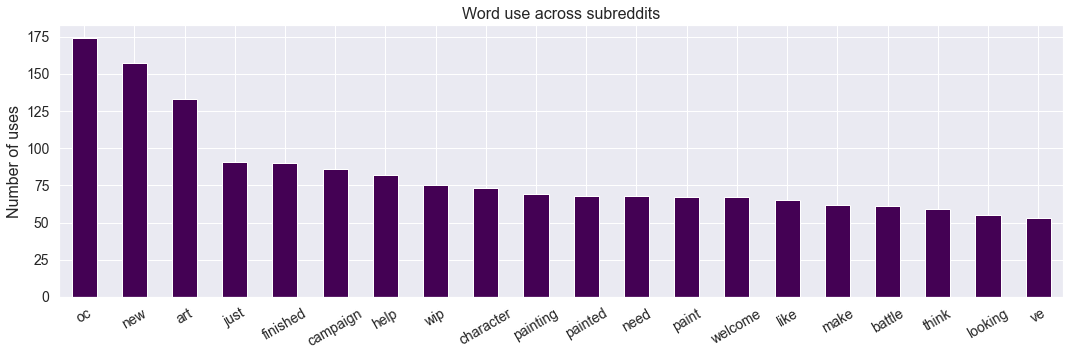

In [12]:
plt.figure(figsize = (18, 5))
titledf.sum().sort_values(ascending=False).head(20).plot(kind='bar', cmap='viridis', fontsize=14)
plt.ylabel('Number of uses', fontsize=16)
plt.xticks(rotation = 30)
plt.title('Word use across subreddits', fontsize=16) ;

The graph above shows the words that are most frquently used across both subreddits. This is worth looking at to see if there are any common words that will be of particular use to identifying the class of each post or if there are any words that will create noise. Using background knowledge of this subject area words that would be worth looking into in particular are ['just', 'new', 'battle', 'campaign']. It is also worth noting that the words "paint", "painted", and "painting" all appear on this list which typically refers to minatures. This indicates that using a lemmatizer may help build a better model.

In [13]:
title_df.groupby('target1').sum()['just']

target1
0    40
1    51
Name: just, dtype: int64

In [14]:
title_df.groupby('target1').sum()['new']

target1
0    76
1    81
Name: new, dtype: int64

In [15]:
title_df.groupby('target1').sum()['battle']

target1
0    35
1    26
Name: battle, dtype: int64

In [16]:
title_df.groupby('target1').sum()['campaign']

target1
0    85
1     1
Name: campaign, dtype: int64

In [17]:
df_dnd = title_df[title_df['target1'] == 0]
df_40k = title_df[title_df['target1'] == 1]
word_list = ['just', 'new', 'battle', 'campaign']

In [18]:
def word_bar_plot(word_li, df_dnd, df_40k):
    dnd_sums = [df_dnd[i].sum() for i in word_li]
    _40k_sums = [df_40k[i].sum() for i in word_li]
    n = len(dnd_sums)
    ind = np.arange(n) 
    width = 0.35       
    # Code below modified from https://benalexkeen.com/bar-charts-in-matplotlib/
    sns.set()
    plt.figure(figsize = (15,7))
    plt.bar(ind, dnd_sums, width, label='DnD', color='#73d055ff')
    plt.bar(ind + width, _40k_sums, width, label='40k', color='#39568cff')

    plt.ylabel('Number of uses', fontsize=16)
    plt.title('Word use per subreddit', fontsize=18)

    plt.xticks(ind + width / 2, word_li, fontsize=14)
    plt.legend(loc='best')
    plt.show()

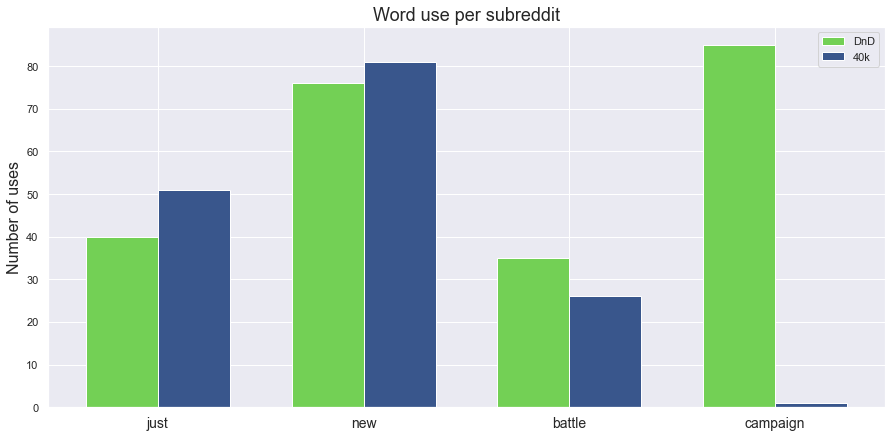

In [19]:
word_bar_plot(word_list, df_dnd, df_40k)

The words "just", "new", and  "battle" are worth removing as they are frequently used and simply create noise. Surprisingly, based on knowledge of these topics, "campaign" is a good word to include as it should be a good predictor of various posts' category.
Below I will create a new list of stop words and lemmatize words. I will start with verbs rather than nouns based on my best guess as to how these words are commonly used.

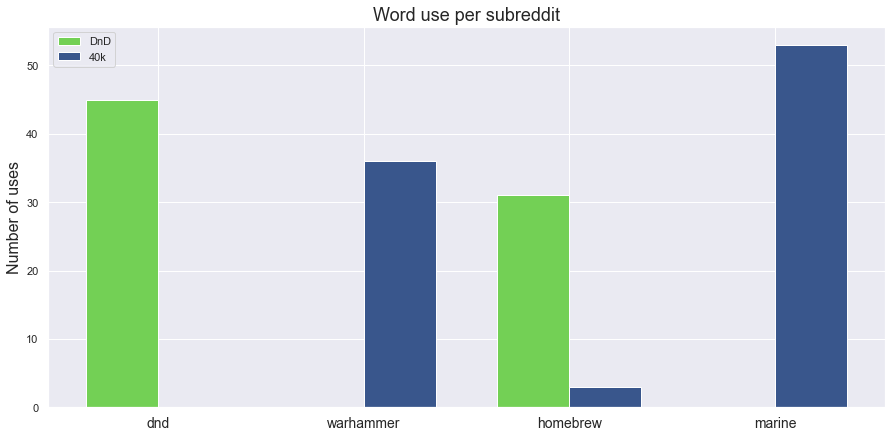

In [20]:
word_list = ['dnd', 'warhammer', 'homebrew', 'marine']
word_bar_plot(word_list, df_dnd, df_40k)

The words above illustrate some of the more obvious indicators of each group. The words "DnD" and "Warhammer" are the titles of the actual RPG that the subreddits are about and the words "homebrew" and "marine" refer to specific aspects of the resptive RPGs.

In [21]:
#Create a new list of stop words by taking the original in CountVectorizer and adding some others that create noise
new = list(CountVectorizer(stop_words = 'english').get_stop_words()) + ['just', 'new', 'battle']

In [22]:
def lemm(df):
    #Using NLTK lemmatizer on verbs, nouns, then adjectives
    lemmer=WordNetLemmatizer()
    # Lemmatize assuming verbs
    df['title_lem'] = df['title'].map(lambda text: ' '.join([lemmer.lemmatize(word, 'v') for word in text.split(' ')]))
    # Lemmatize assuming nouns
    df['title_lem'] = df['title_lem'].map(lambda text: ' '.join([lemmer.lemmatize(word) for word in text.split(' ')]))
    # Lemmatize assuming adjectives
    df['title_lem'] = df['title_lem'].map(lambda text: ' '.join([lemmer.lemmatize(word, 'a') for word in text.split(' ')]))
    return df

In [23]:
df = lemm(df)

In [24]:
#This time I will also be altering the token pattern to ensure that numbers that are split on "." or "," are left together
#I have also altered ngrams_range to allo for word pairs 
def CVec(df):
    cvec = CountVectorizer(ngram_range=(1,2), stop_words = new, min_df = 3, token_pattern='\\b(\\w+[\\.,]?\\w+)\\b')
    cv_s = cvec.fit_transform(df['title_lem'])
    cvpdf = pd.DataFrame(cv_s.todense(), columns=cvec.get_feature_names())
    df_cvec = pd.concat([cvpdf, df], axis=1)
    print(df_cvec.shape)
    return cvpdf, df_cvec

In [25]:
titledf3, title_df3 = CVec(df)

(2574, 1405)


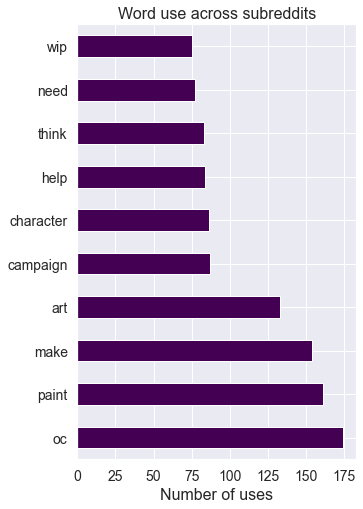

In [26]:
#Show top ten words
plt.figure(figsize = (5,8))
titledf3.sum().sort_values(ascending=False).head(10).plot(kind='barh', cmap='viridis', fontsize=14)
plt.xlabel('Number of uses', fontsize=16)
plt.title('Word use across subreddits', fontsize=16) ;

The graph above shows the word frequency of the top ten words in this data set. There are still no word pairs in the top ten however lemmatizing has reduced three versions of the word "paint" into one and pushed it closer to the top of the list. I will use these same parameters to test various classification models.

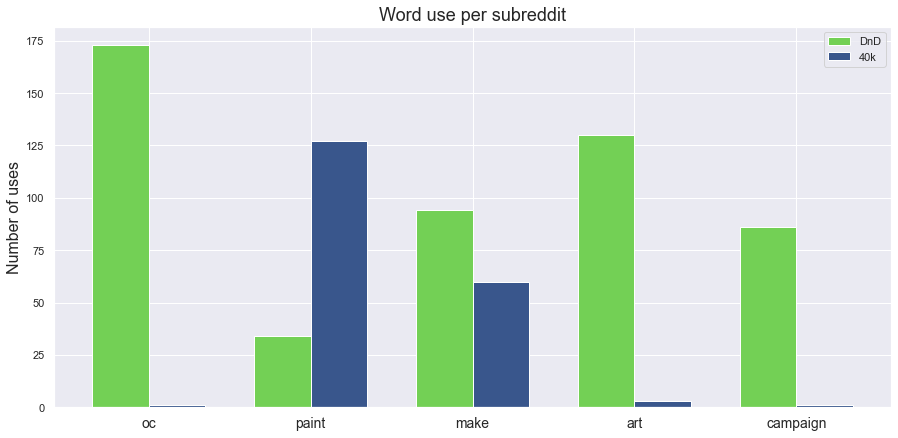

In [27]:
df_dnd2 = title_df3[title_df3['target1'] == 0]
df_40k2 = title_df3[title_df3['target1'] == 1]
word_list2 = ['oc', 'paint', 'make', 'art', 'campaign']
word_bar_plot(word_list2, df_dnd2, df_40k2)

The barchart above shows the 5 most frequently used words across both subreddits based on the reddit with their frequency in each subreddit. These words have very different frequencies in each set which will make them useful in classification models.

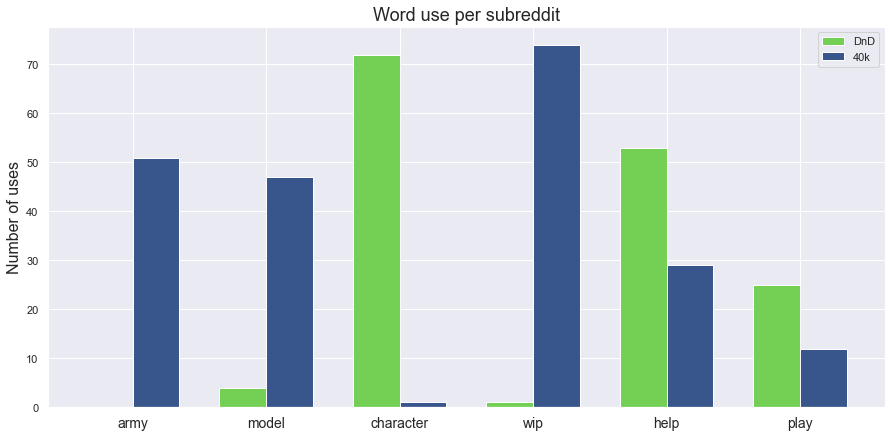

In [28]:
# More fun words based on knowledge of the topic!
word_list3 = ['army', 'model', 'character', 'wip', 'help', 'play']
word_bar_plot(word_list3, df_dnd, df_40k)

The graph above shows other fun words commonly associated with these RPGs and their frequency in each group.

## Modeling
### Naïve Bayes

In [29]:
#Split into feature and target
X = df['title_lem'] #double brackets for function
y = df['target1']
#Print y baseline again as a reminder of the goal
y.value_counts(normalize=True)

1    0.501554
0    0.498446
Name: target1, dtype: float64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y, # ensure there is the same distribution of y in each group
                                                    random_state=42)

In [31]:
# CountVectorize using same parameters as above
# Note that there are less columns in this data set. Splitting these data means losing many of the words to use as features
cvec = CountVectorizer(ngram_range=(1,2), stop_words = new, min_df = 3, token_pattern='\\b(\\w+[\\.,]?\\w+)\\b')
X_train_cv = cvec.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())
X_train_df.shape

(1724, 954)

In [32]:
X_test_cv = cvec.transform(X_test)
X_test_df = pd.DataFrame(X_test_cv.todense(), columns=cvec.get_feature_names())
X_test_df.shape

(850, 954)

In [33]:
nb = MultinomialNB()
cross_val_score(nb, X_train_df, y_train, cv=5).mean()

0.8735473542298617

In [34]:
def fit_n_score(model, X1, y1, X2, y2):
    model.fit(X1, y1)
    print(f'Training accuracy score: {round(model.score(X1, y1), 5)}')
    print(f'Testing accuracy score:  {round(model.score(X2, y2), 5)}')

In [35]:
# nb.fit(X_train_df, y_train)
# nb.score(X_train_df, y_train), nb.score(X_test_df, y_test)
fit_n_score(nb, X_train_df, y_train, X_test_df, y_test)

Training accuracy score: 0.91763
Testing accuracy score:  0.83882


In [36]:
def con_plot(model, X, y, title):
    sns.set_style("white")
    metrics.plot_confusion_matrix(model, X, y, cmap='Blues', 
                          values_format='d', display_labels=['DnD', '40k'])
    plt.title(f'Confusion matrix of predicted versus \n actual subreddit category in {title}', fontsize=16)
    plt.show();

def con_mets(model, X2, y2):
    preds = model.predict(X2)
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y2, preds).ravel()
    print(f'Type I error')
    print(f'Specificity: {tn / (fp + tn)}')
    print(f'Sensitivity: {tp / (fn + tp)}')
    print(f'Precision:   {tp / (tp + fp)}')

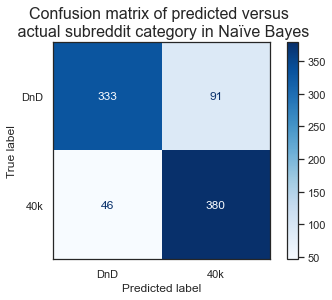

In [37]:
con_plot(nb, X_test_df, y_test, 'Naïve Bayes')

In [38]:
con_mets(nb, X_test_df, y_test)

Type I error
Specificity: 0.785377358490566
Sensitivity: 0.892018779342723
Precision:   0.8067940552016986


The confusion matrix and other metrics above are a little confusing because there is not truly have a "positive" value that is being targeted. Accuracy is the best metric to indicate how the model is performing with these data. However, the matrix and other scoring metrics above offer valuable insight into what the model is performing well on and what might be reducing accuracy. For the puroposes of these data specificity will always be relative to posts coming from r/DungeonsandDragons, sensitivity will be relative to posts that came from r/Warhammer40k, and precision will be relative to all the posts that were predicted to come from r/Warhammer40k.

The Confusion Matrix above shows that relative to 40k, this model is has a high number of "false positives," which, in this case means the model predicts 40k frquently when the post actually came from the DnD site. This is supported by the relatively low specificity score.

It is worth noting that you can also use TF-IDF to vectorize the corpus Which will help determine which words may be more indicative of one category relative to the other. This did not provide any benefit to the modeling for this data set and is therefore not included.

### Random Forest

In [39]:
# Instantiate model
rf = RandomForestClassifier()

In [40]:
cross_val_score(rf, X_train_df, y_train, cv=5).mean()

0.8364341085271316

In [41]:
fit_n_score(rf, X_train_df, y_train, X_test_df, y_test)

Training accuracy score: 0.97506
Testing accuracy score:  0.80118


The random forest model, despite including several different decision tree models, is incredibly over fit. Unfortunately adding penalties or constraints (max_depth) on branch depth does not improve the models performance indicating that random forest is not a good candidate.

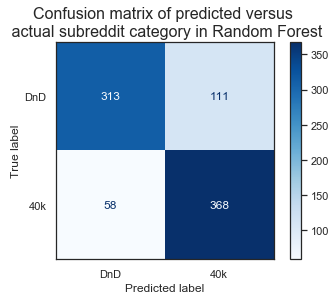

In [42]:
con_plot(rf, X_test_df, y_test, 'Random Forest')

The confusion matrix above indicates that the random forest model makes similar errors that the Naïve Bayes model but unfortunately makes them at a higher frequency.

### ADA Boost

In [43]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [44]:
fit_n_score(ada, X_train_df, y_train, X_test_df, y_test)

Training accuracy score: 0.97506
Testing accuracy score:  0.79529


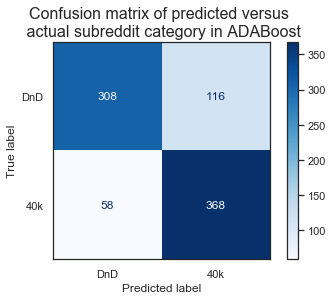

In [45]:
con_plot(ada, X_test_df, y_test, 'ADABoost')

The confusion matrix above indicates that the ADABoost model makes similar errors that the Naïve Bayes and Random Forest model. However, the "false positive" or false prediction of a post being on r/Warhammer40k is much higher despite though "false negative" or false prediction of a post coming from r/DungeonsandDragons is lower.

### Grid Search using best model

Naïve Bayes was the best model, and grid searching through the parameters should improve the model slightly.

In [46]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = new, token_pattern='\\b(\\w+[\\.,]?\\w+)\\b')),
    ('nb', MultinomialNB())
])

h_params = {
    'cvec__max_features': [None, 500, 700],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1, 10, 100]
}

In [47]:
cv_folds = StratifiedKFold(shuffle=True, random_state=42) # 5-fold cross-validation, necessary for sorted dataframe
gs = GridSearchCV(pipe, h_params, cv = cv_folds)

In [48]:
fit_n_score(gs, X_train, y_train, X_test, y_test)

Training accuracy score: 0.93852
Testing accuracy score:  0.85882


In [49]:
gs.best_params_

{'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 1}

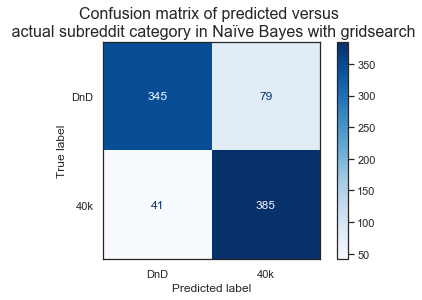

In [50]:
con_plot(gs, X_test, y_test, 'Naïve Bayes with gridsearch')

In [51]:
con_mets(gs, X_test, y_test)

Type I error
Specificity: 0.8136792452830188
Sensitivity: 0.903755868544601
Precision:   0.8297413793103449


Using the hyperparameters found in GridSearch did improve the Naïve Bayes model somewhat. However this model still has high variance. Additionally this model continues to suffer from over predicting r/Warhammer40k subreddit as the other models have. Specificity does have a large improvement over all previous models but the sensitivity is still much higher indicating that the model continues to struggle predicting r/DungeonsAndDragons.

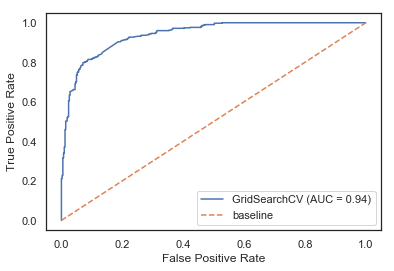

In [52]:
plot_roc_curve(gs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

The ROC curve above shows that, despite this model over predicting r/Warhammer40k, overall the model does separate the data well reinforcing the overall good accuracy score.

### Testing on some new data

The data I will look at now are actually from two new subreddits. While before I used r/DungeonsandDragons and r/Warhammer40k this new data set was pulled from r/DnD and r/40k. These new subreddits are analgous to the original which provides an excellent way to test this model on data that did not contribute to deciscions made during the exploratory data analysis.

In [53]:
al_df = pd.read_csv('../data/alt_reddit_posts.csv')
al_df.drop(columns=['Unnamed: 0'], inplace=True)
al_df = clean_data(al_df)
al_df.head()

,title,score,comms_num,body,target1,body_wc,title_wc
0,DM help,1,0,Is it a good idea as a DM (who is creating a c...,0,97,2
1,Need Unique assassin qwerks or style,1,0,I’m designing a assassin guild style system an...,0,83,6
2,Is frost fingers just a worse burning hands?,1,1,"I was looking at the icewind dale spell, frost...",0,103,8
3,How to unlock fast travel,1,7,I need to unlock fast travel in my game it s 5...,0,27,5
4,3 Free Mini Adventures!,1,0,Check them out for free on my Patreon page. Li...,0,33,4


In [54]:
al_df=lemm(al_df)
al_df.shape

(1998, 8)

In [55]:
al_X = al_df['title_lem']
al_y = al_df['target1']
gs.score(al_X, al_y)

0.8588588588588588

notes about score

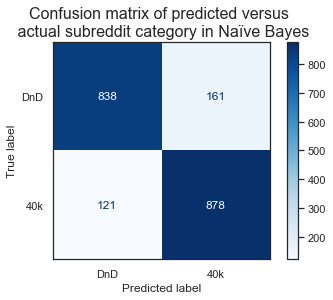

In [56]:
con_plot(gs, al_X, al_y, 'Naïve Bayes')

In [57]:
con_mets(gs, al_X, al_y)

Type I error
Specificity: 0.8388388388388388
Sensitivity: 0.8788788788788788
Precision:   0.8450433108758422


While accuracy rate of 85.9% is not overwhelmingly high, achieving this score on completely unseen data indicates that decisions that were made during EDA were not the major cause of this model overfitting based on how close this accuracy is to the test subset of data. Furthermore the results appear to be reproducible indicating that this model would likely continue to perform at about this level of accuracy for posts in the future. 


## Conclusions and recomendations
This final model makes has a good initial accuracy at guessing which subreddit a post is likely to be related to. This model does well given limited text. Investigating the posts that were misclassifid to see if a human would have an easier time classifying them would be a good step to indicate features that the model is not picking up on. To improve this score in the future the next step would be an analysis of the body rather than just title. Since much of the content posted on these pages is art it would be worth analysing the images as well to get the best accuracy. Using GridSearch across more models using, different vectorizing techniques, and hyperparameters may produce an even better pairing for a final model than I was able to find.

Adding in other role playing game subreddits, while decreasing accuracy may help differentiate words that are important to each group a little more. Many role playing games are science fiction and fantasy fiction based therefore words that are not related to the genre and more related to the mechanics of each individual game may become more clear with such data.